<h1 style="color : blue">import librarys that we need</h1>

In [63]:
import pandas as pd  # using to process the data
import numpy as np  # use to calculate and mathematic
import matplotlib.pyplot as plt # use to plot
import seaborn as sns # plot
from sklearn.linear_model import LinearRegression # model that we need
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

simplefilter("ignore")


<h1 style="color : blue">Set Matplotlib defaults</h1>

In [49]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

<h1 style="color : blue">Read The data</h1>

In [50]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2013-07-24', periods=1152, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

,date,well_name,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,thp,tht,choke_size_percentage,QL,QG,well6_inj,well7_inj
0,2013-07-24,15/9-F-11,1.92627,0.35220,26.12304,3.256548,28.04931,18.19463,18.85147,61.200000,9505.611429,2476.0,3070.0
1,2013-07-25,15/9-F-11,163.59426,60.31574,61.47308,8.549131,102.12118,36.96744,72.95519,725.000000,108940.110000,4706.0,4007.0
2,2013-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-07-28,15/9-F-11,0.00000,0.00000,0.00000,2.464222,0.00000,0.00000,0.00000,1600.285714,257479.142857,87.0,146.0


<h1 style="color: blue">selecting the columns that we need and remove NaN values</h1>

In [51]:
df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2013-07-24,1.926270,0.35220,26.123040,3.256548,9505.611429,0
2013-07-25,163.594260,60.31574,61.473080,8.549131,108940.110000,1
2013-07-28,0.000000,0.00000,0.000000,2.464222,257479.142857,4
2013-07-29,0.000000,0.00000,0.000000,2.536987,112755.000000,5
2013-07-31,273.946931,105.55137,179.382345,2.540804,137705.269214,7


<h1 style="color:blue">plot to see the shape of the data</h1>

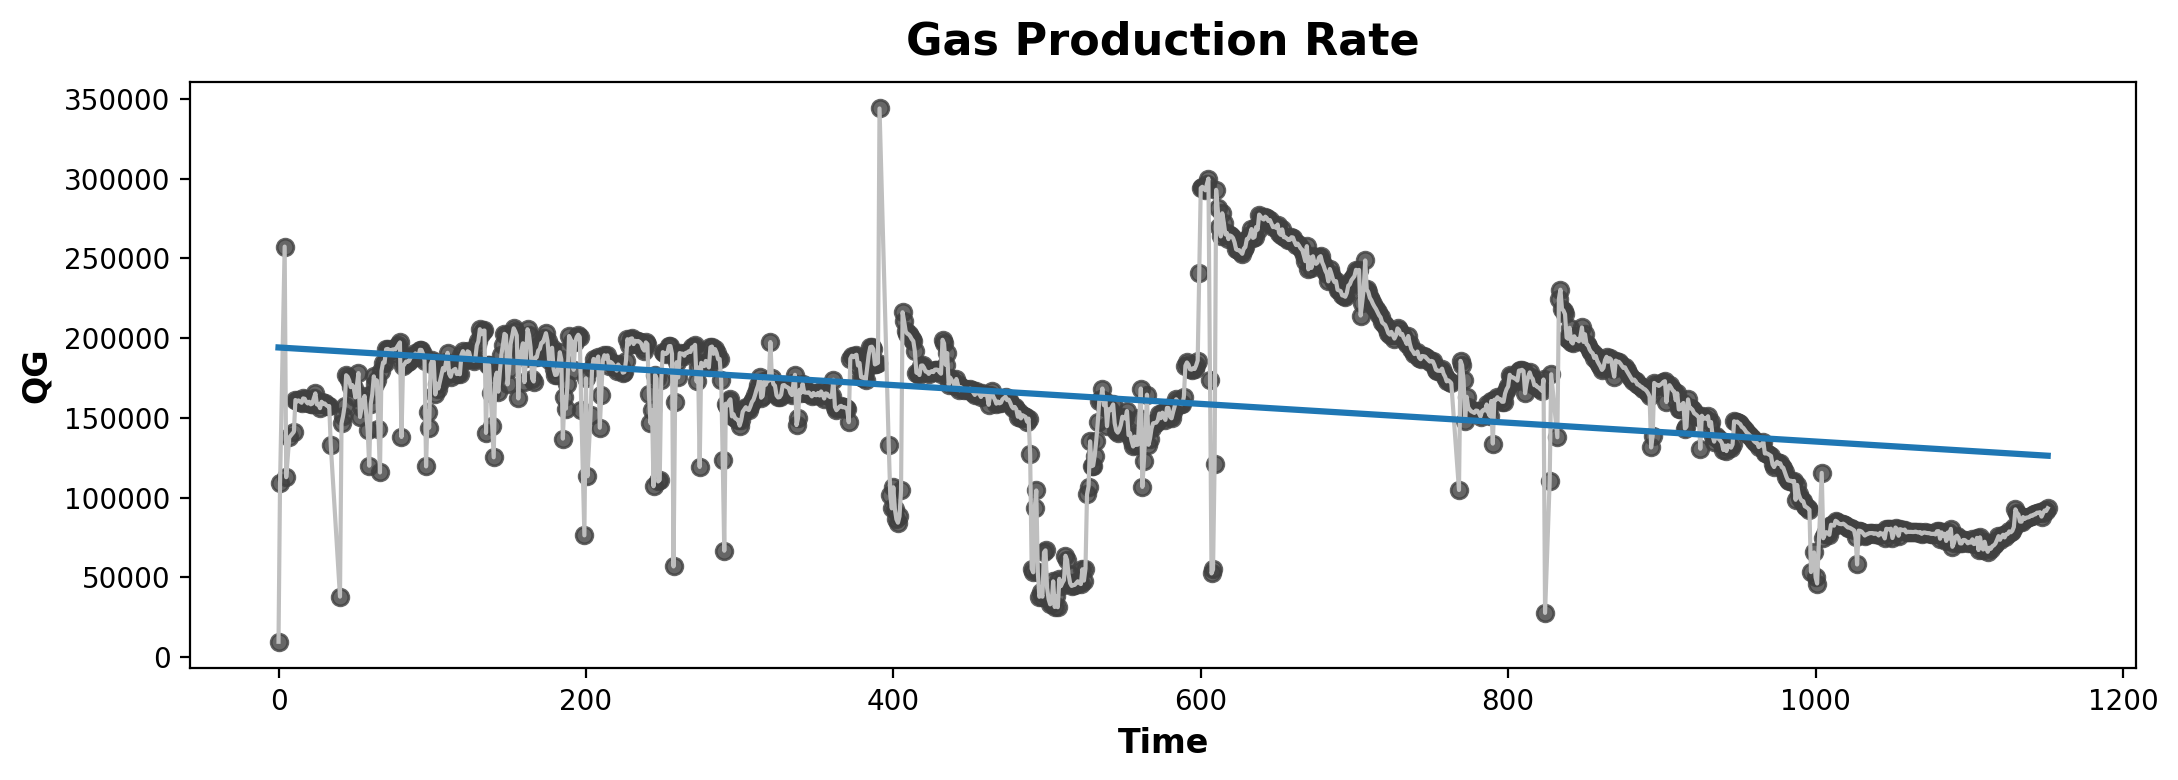

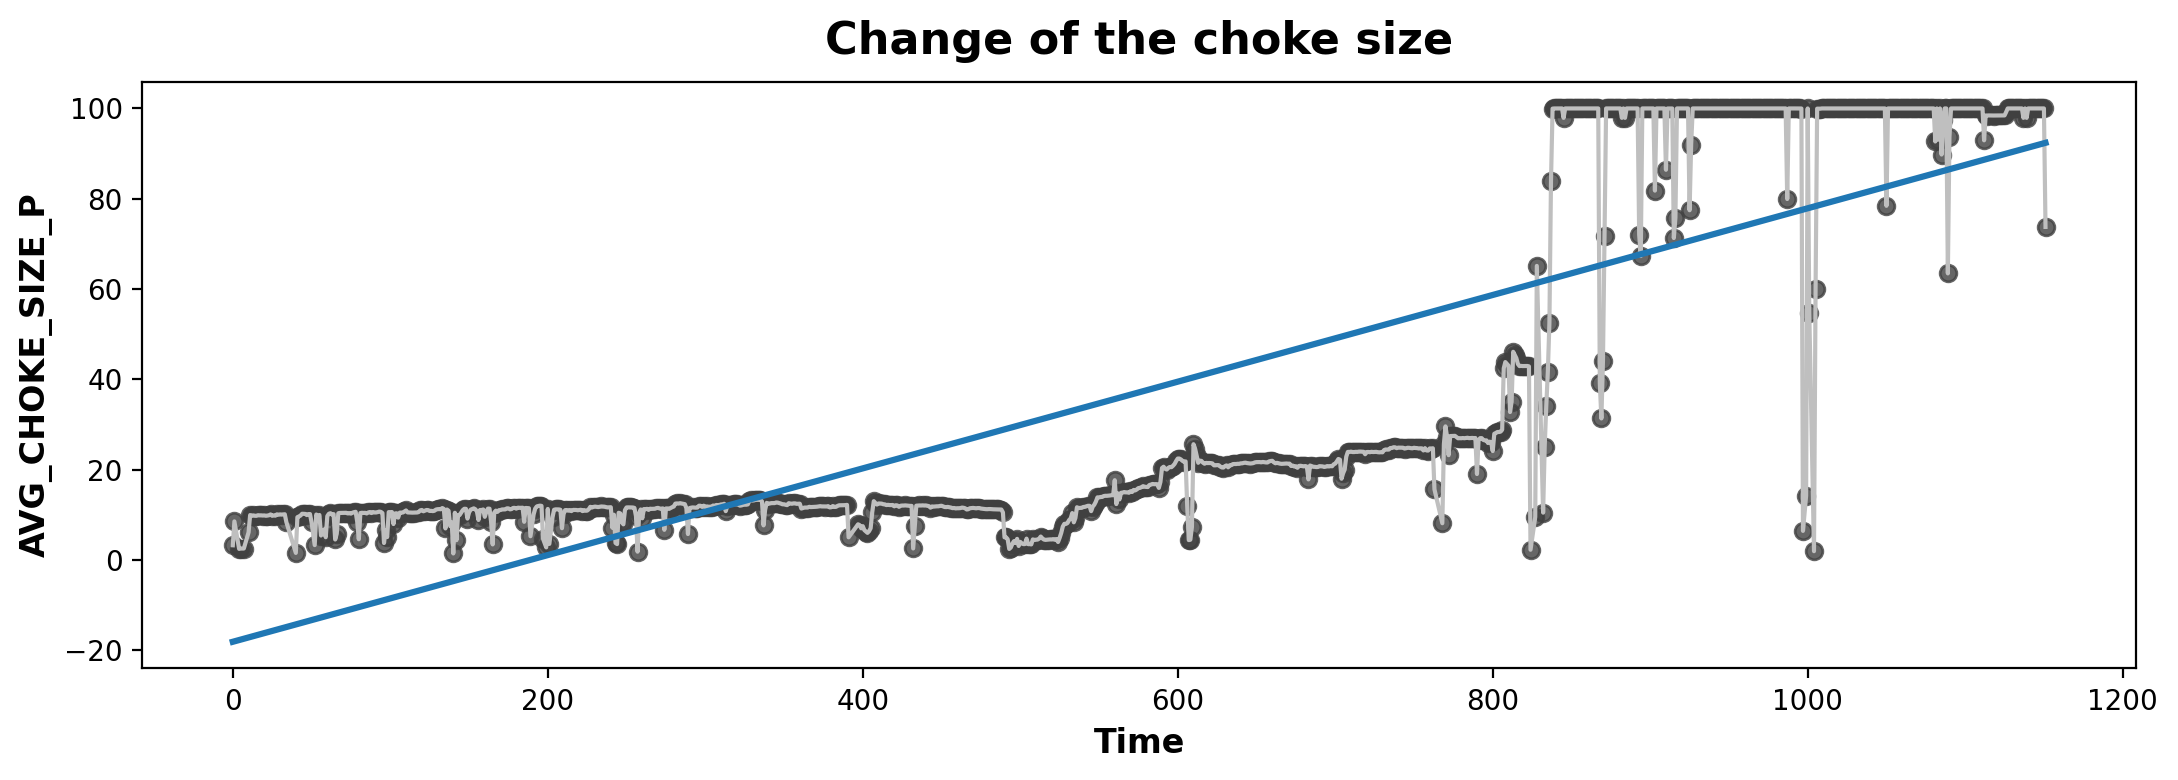

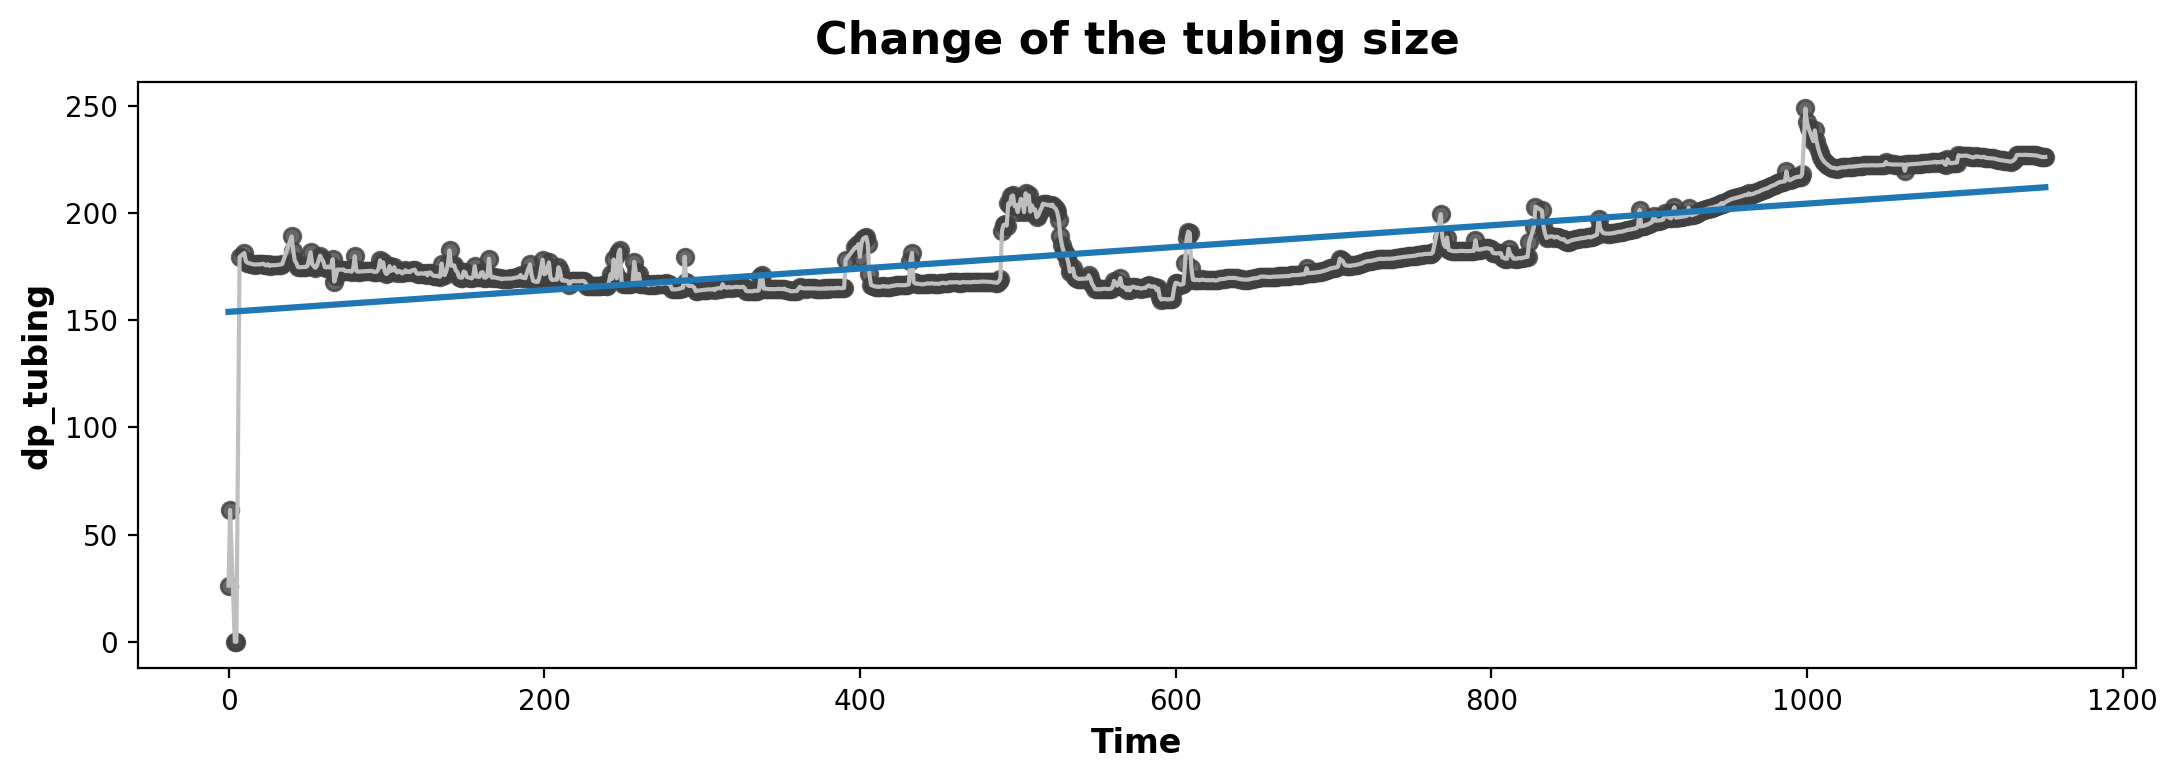

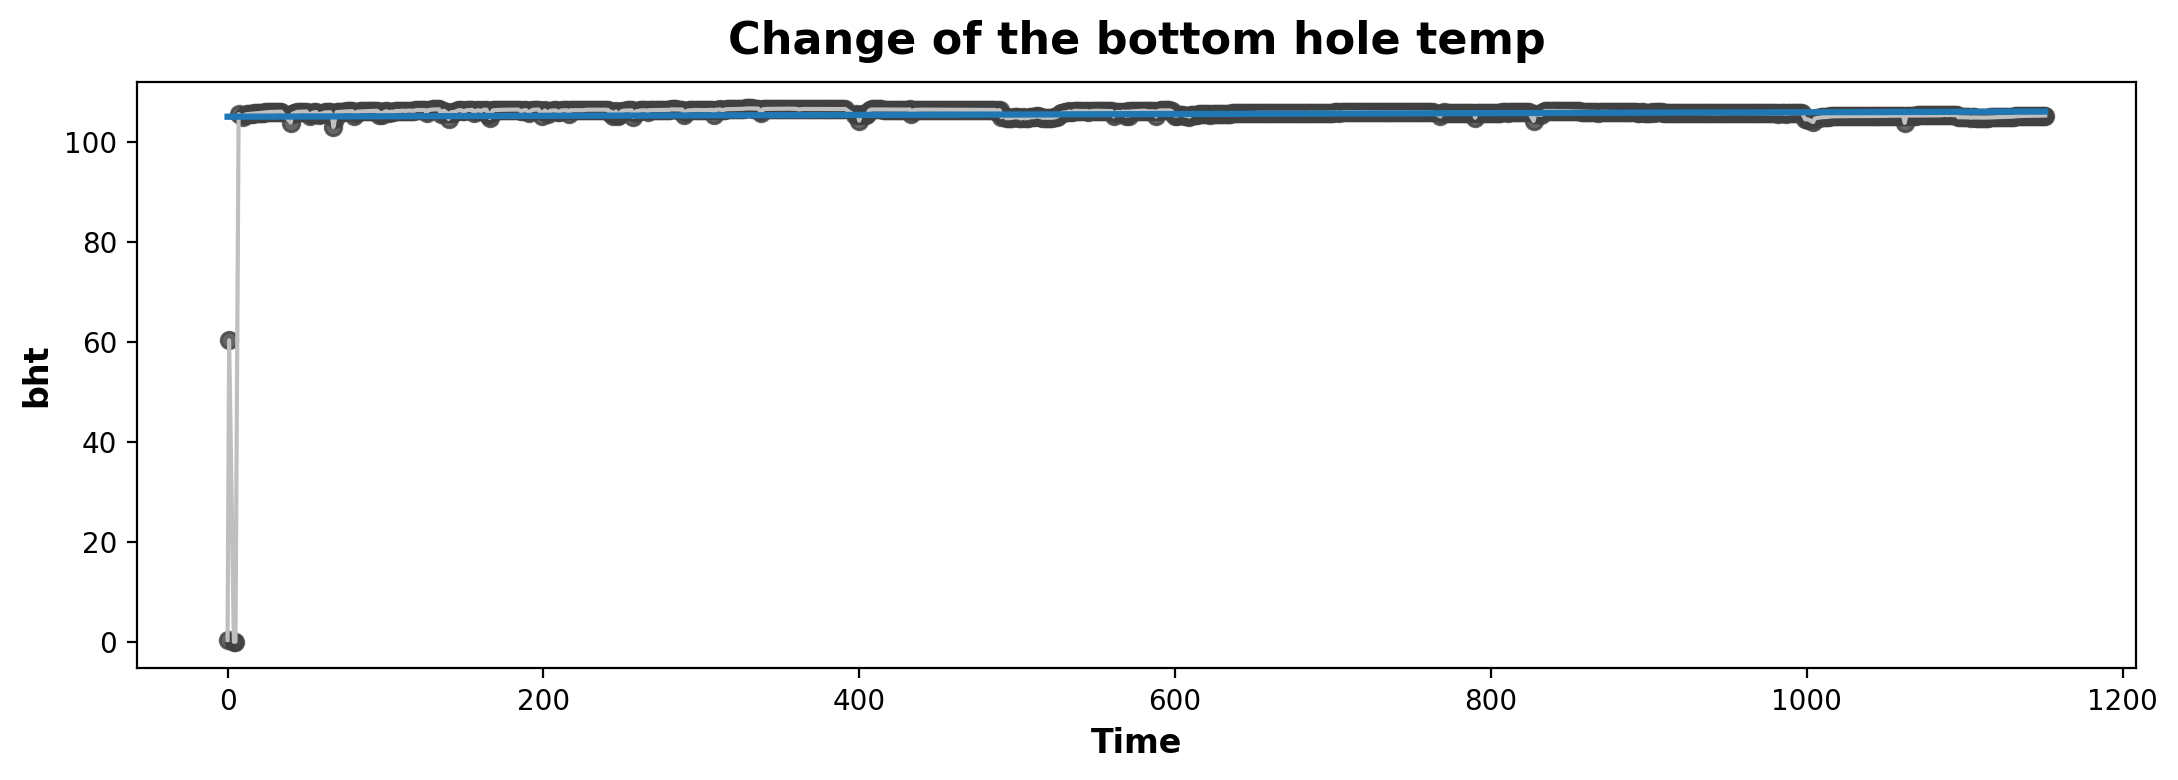

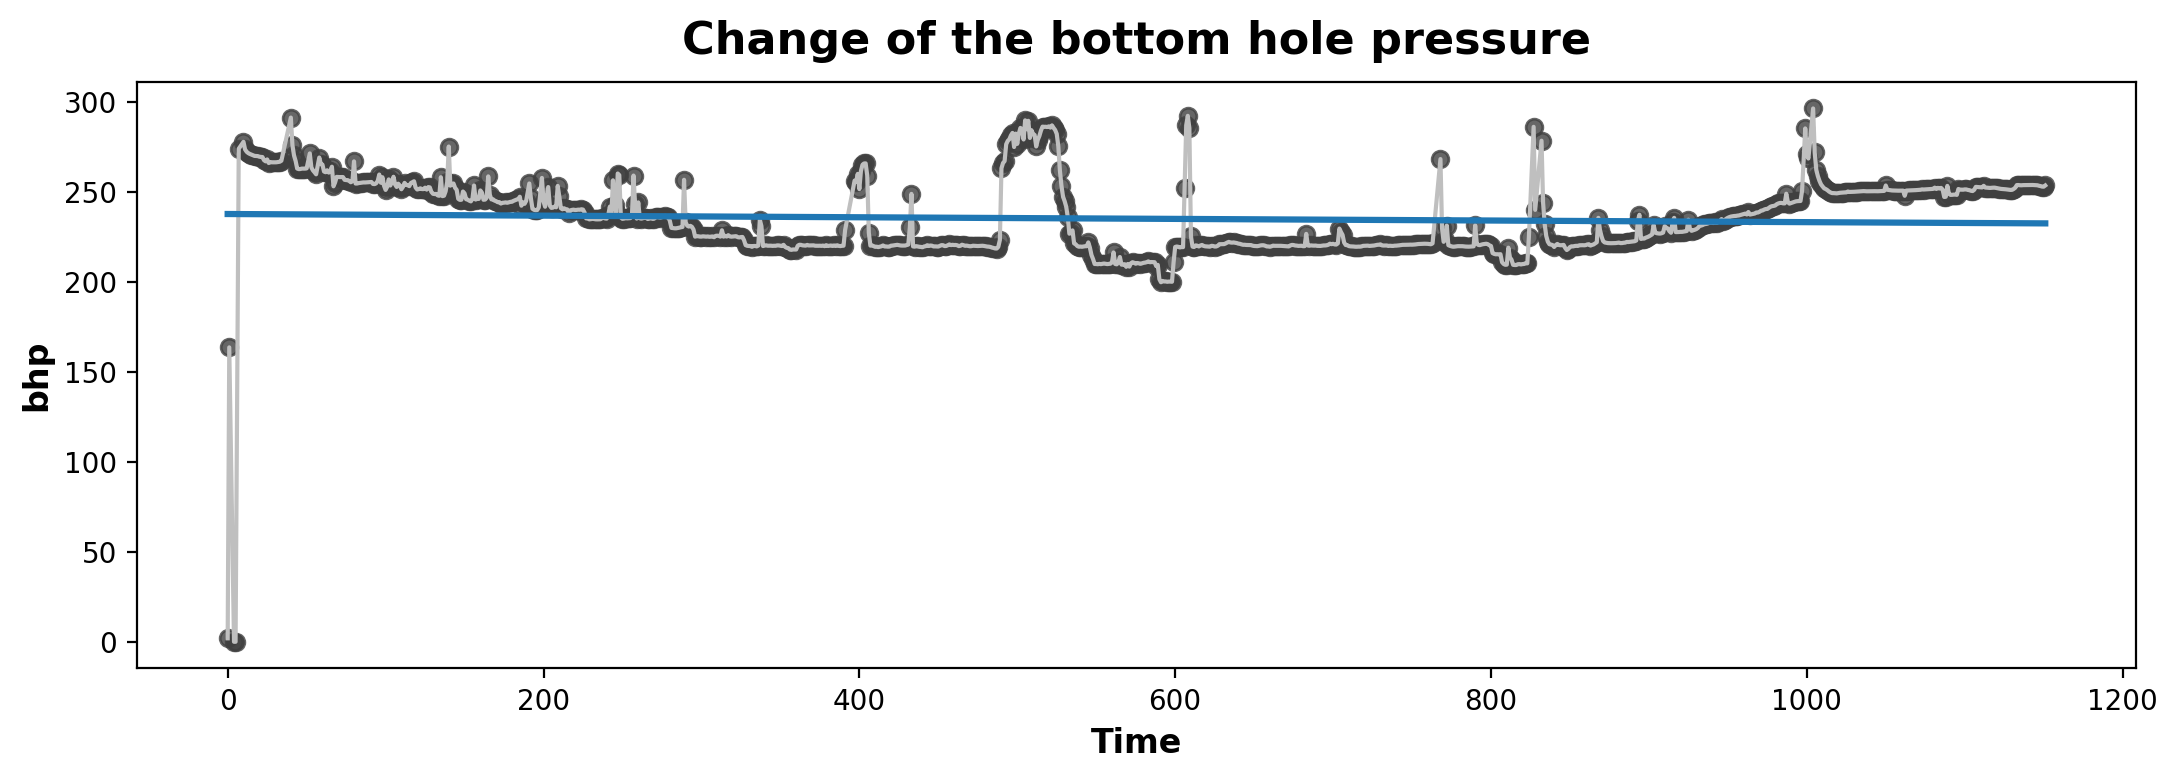

In [52]:
# Define a list of column names and their titles
plot_columns = [
    ('QG', 'Gas Production Rate'),
    ('AVG_CHOKE_SIZE_P', 'Change of the choke size'),
    ('dp_tubing', 'Change of the tubing size'),
    ('bht', 'Change of the bottom hole temp'),
    ('bhp', 'Change of the bottom hole pressure')
]

# Loop through each column and plot
for column, title in plot_columns:
    fig, ax = plt.subplots()
    ax.plot('Time', column, data=df, color='0.75')
    ax = sns.regplot(x='Time', y=column, data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title(title)
    plt.show()

<h1 style=color:blue>plot the moving avrage to see the trend of the production</h1>

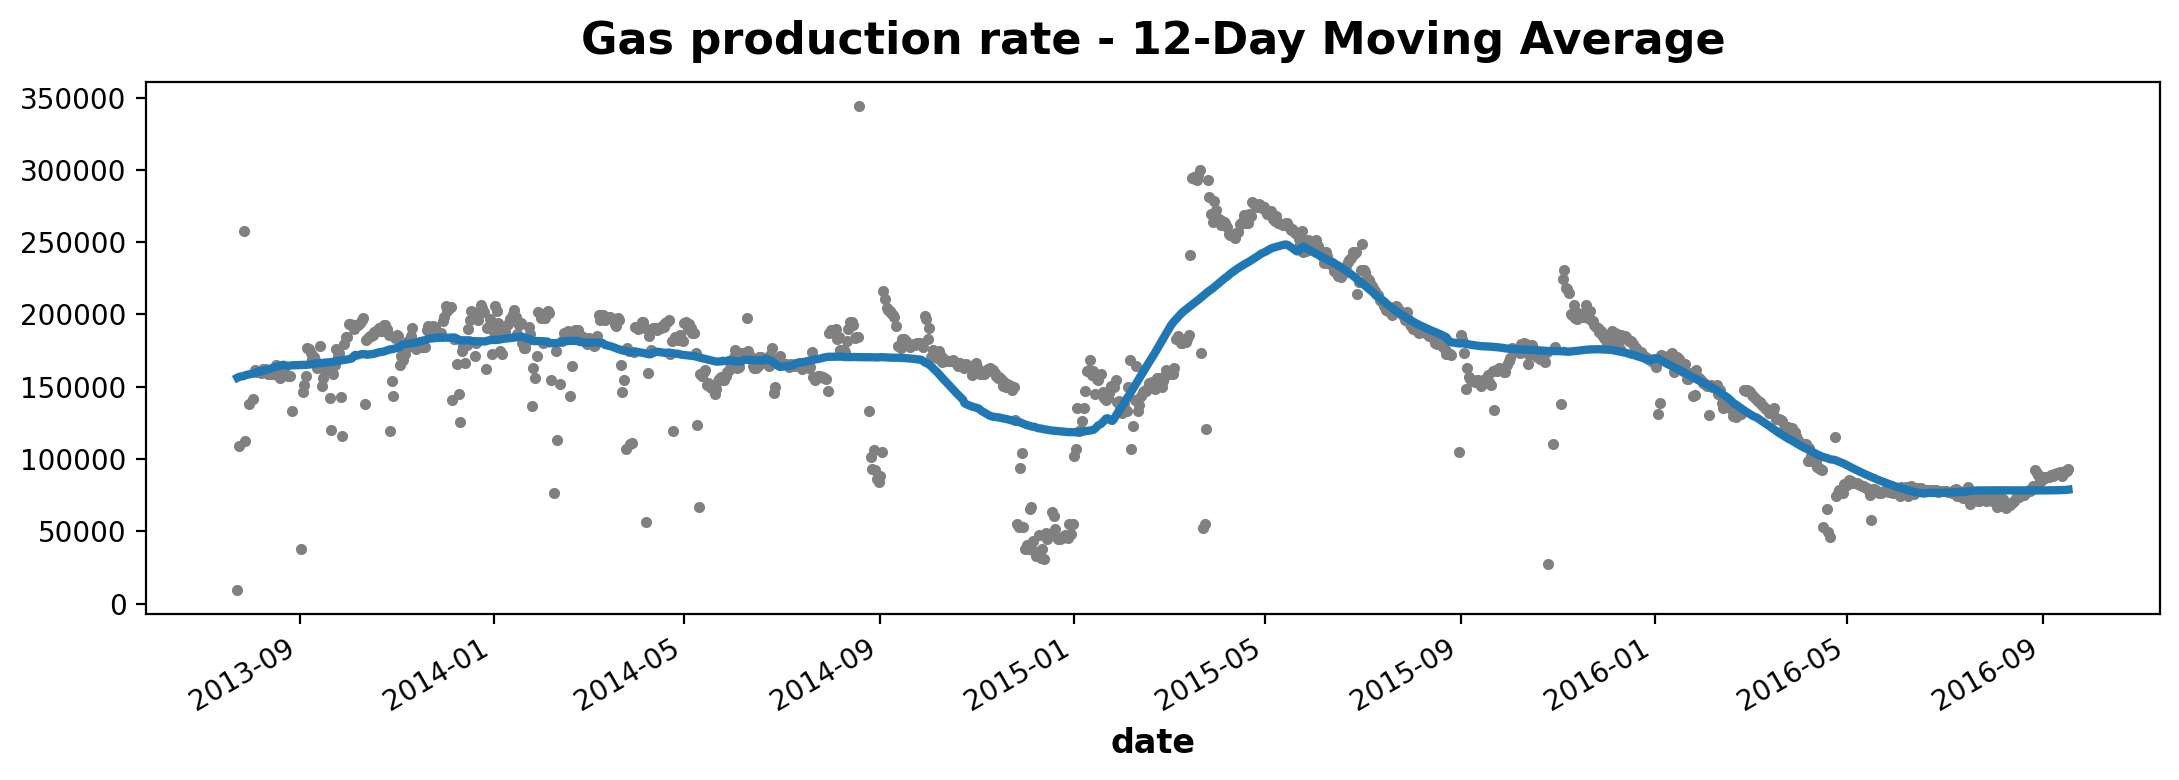

In [53]:
moving_average = df["QG"].rolling(
    window=120,       # 120-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about 1/3 the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df["QG"].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Gas production rate - 12-Day Moving Average", legend=False,
);

<h1 style="color:blue">Checking the correlation between features</h1>

In [54]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
bhp,1.000000,0.504339,0.598116,0.074825,-0.459309,-0.066680
bht,0.504339,1.000000,0.361954,0.010981,0.088489,0.052353
dp_tubing,0.598116,0.361954,1.000000,0.762348,-0.636728,0.734822
AVG_CHOKE_SIZE_P,0.074825,0.010981,0.762348,1.000000,-0.416430,0.833444
QG,-0.459309,0.088489,-0.636728,-0.416430,1.000000,-0.363436
Time,-0.066680,0.052353,0.734822,0.833444,-0.363436,1.000000


<h1 style="color:blue">mi_score</h1>

In [55]:
X = df.copy()
y = X.pop("QG")

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
# mi_scores[::3]  # show a few features with their MI scores
mi_scores

Time                2.005643
dp_tubing           1.483513
bhp                 1.118092
bht                 0.980004
AVG_CHOKE_SIZE_P    0.974266
Name: MI Scores, dtype: float64

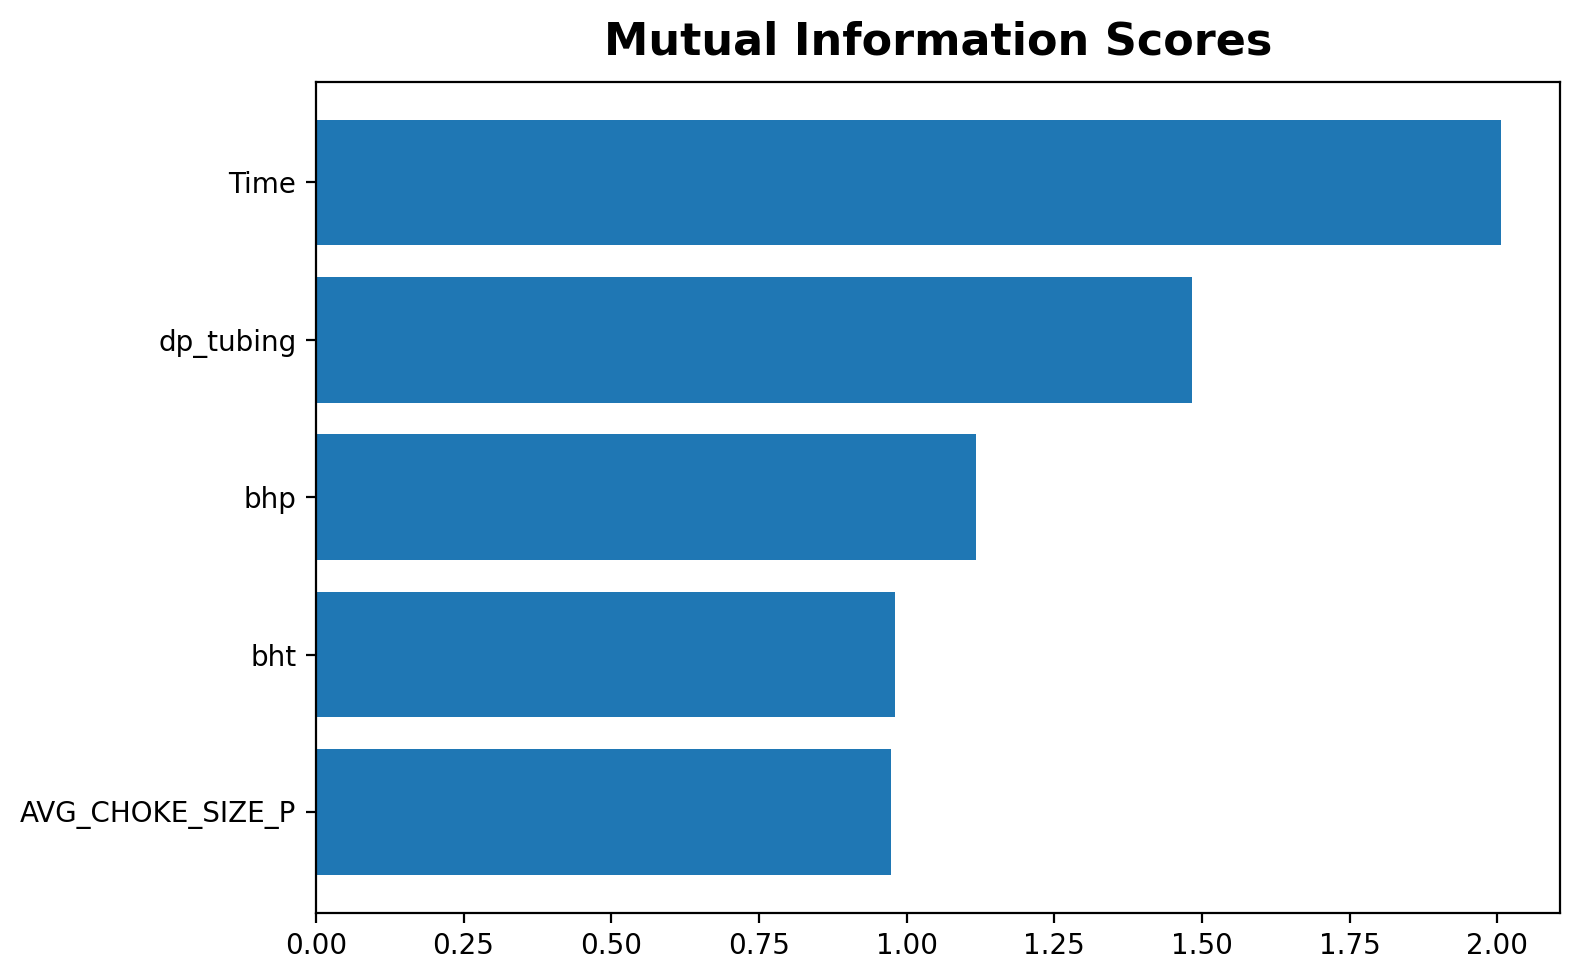

In [56]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [81]:
    # Normalize features 
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.values)
    series = pd.DataFrame(scaled, columns=["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "QG", "Time"])
    print(series.head())
    print(series.shape)

        bhp       bht  dp_tubing  AVG_CHOKE_SIZE_P        QG      Time
0  0.006500  0.003301   0.105036          0.018396  0.000000  0.000000
1  0.552022  0.565286   0.247172          0.072097  0.297135  0.000869
2  0.000000  0.000000   0.000000          0.010357  0.741006  0.003475
3  0.000000  0.000000   0.000000          0.011095  0.308534  0.004344
4  0.924389  0.989239   0.721265          0.011134  0.383092  0.006082
(1119, 6)


<h1 style="color : blue">Split train and test and x and y</h1>

In [154]:
# creating a function to make a lag from data set
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]

# Create three lags for each search term
X0 = make_lags(series[search_terms], lags=4)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(series['QG'], lags=4)

# save now condition
X2 = series[search_terms]

# Combine to create the training data
X = pd.concat([X0, X1, X2], axis=1).fillna(0.0)

y = series.QG.copy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20
#                                                     , shuffle=False)

# Split data into training (70%) and test (30%)
nrow = round(0.7*X.shape[0])
X_train = X.iloc[:nrow, :]
y_train = y[:nrow]
X_test = X.iloc[nrow:,:]
y_test = y[nrow:]

In [155]:
X_train = X_train.values.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(783, 29, 1)
(336, 29, 1)


In [156]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (29,1), units= 29, return_sequences = True))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(8))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 29, 29)              │           3,596 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 29, 64)              │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,005 (117.21 KB)

 Trainable params: 30,005 (117.21 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(X_train, y_train, epochs=250, batch_size=70, validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=25), checkpoint], verbose=1, shuffle=False)
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)
     

Epoch 1/250
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1808
Epoch 1: val_loss improved from inf to 0.00655, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.1668 - val_loss: 0.0065
Epoch 2/250
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0567
Epoch 2: val_loss did not improve from 0.00655
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0589 - val_loss: 0.0087
Epoch 3/250
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0404
Epoch 3: val_loss improved from 0.00655 to 0.00291, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0438 - val_loss: 0.0029
Epoch 4/250
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0371
Epoch 4: val_loss did not improve from 0.00291
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0409 - val_loss: 0.0047
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0424
Epoch 5: val_loss did not improve from 0.00291
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0432 - val_l

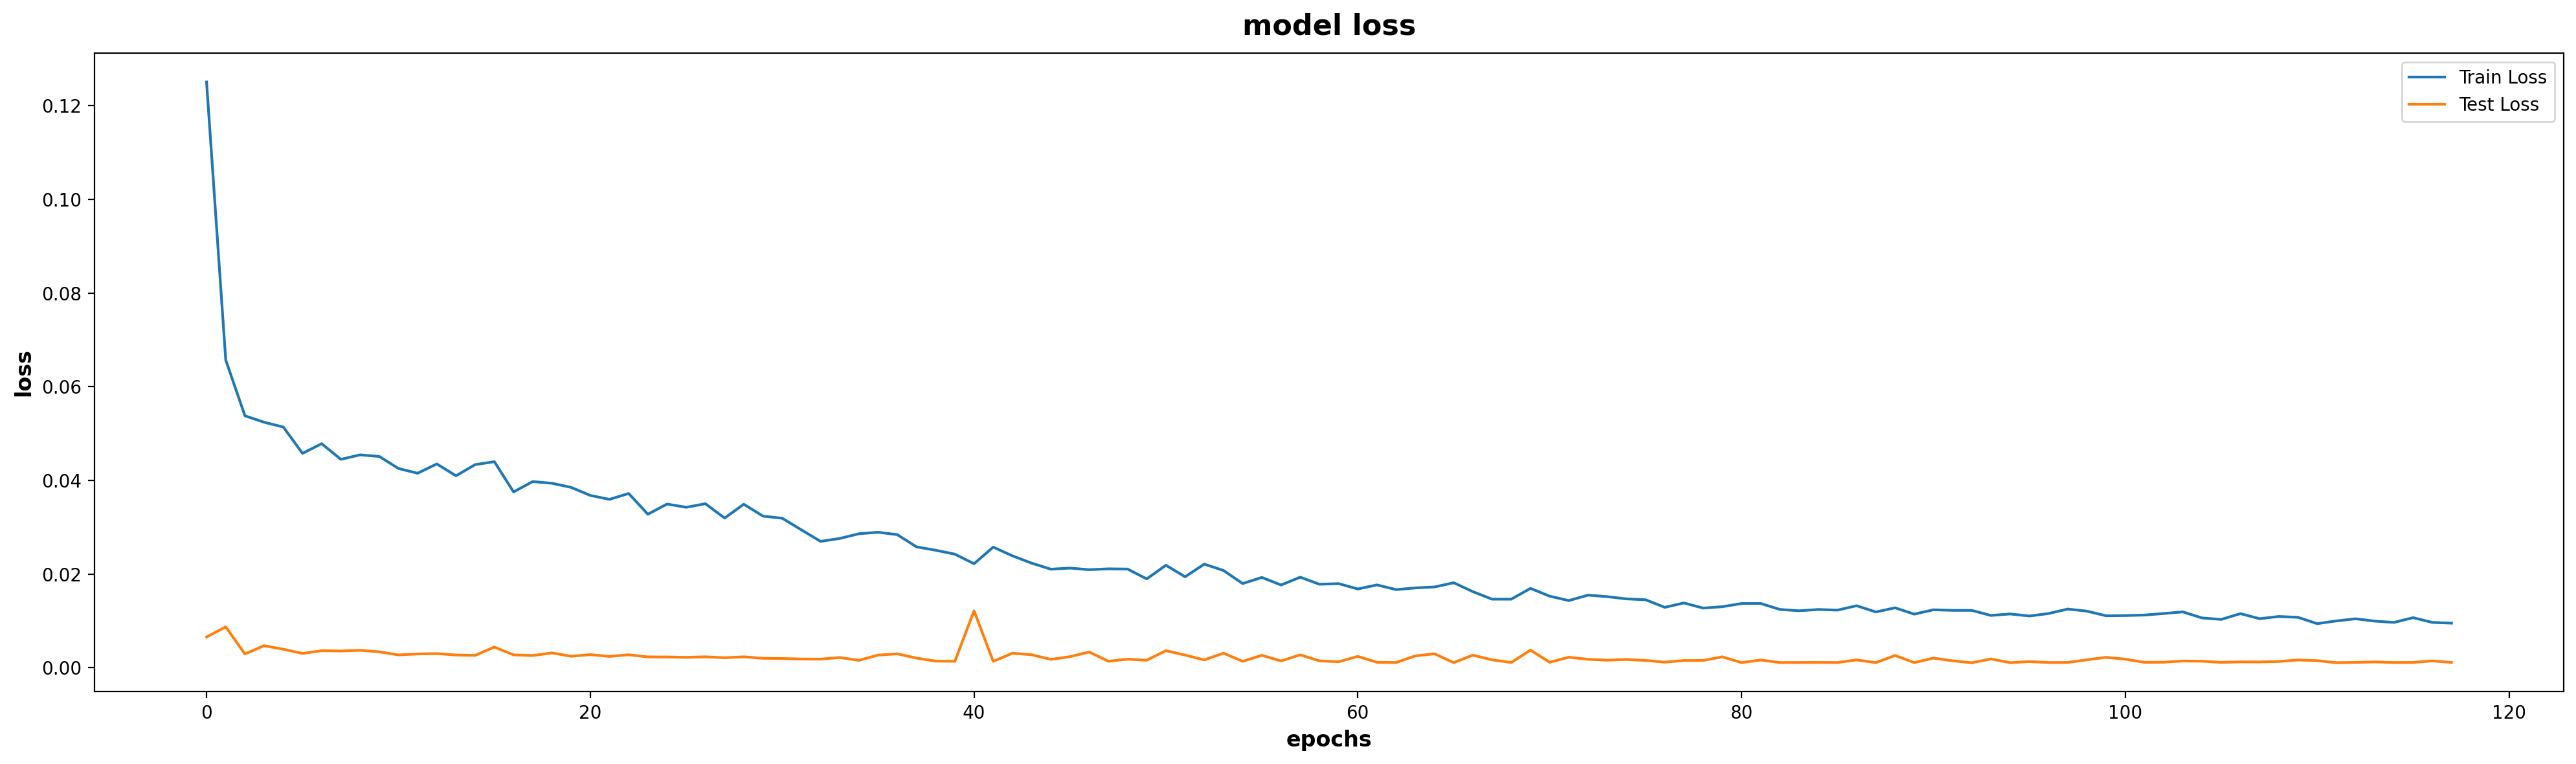

In [158]:

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()
     

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


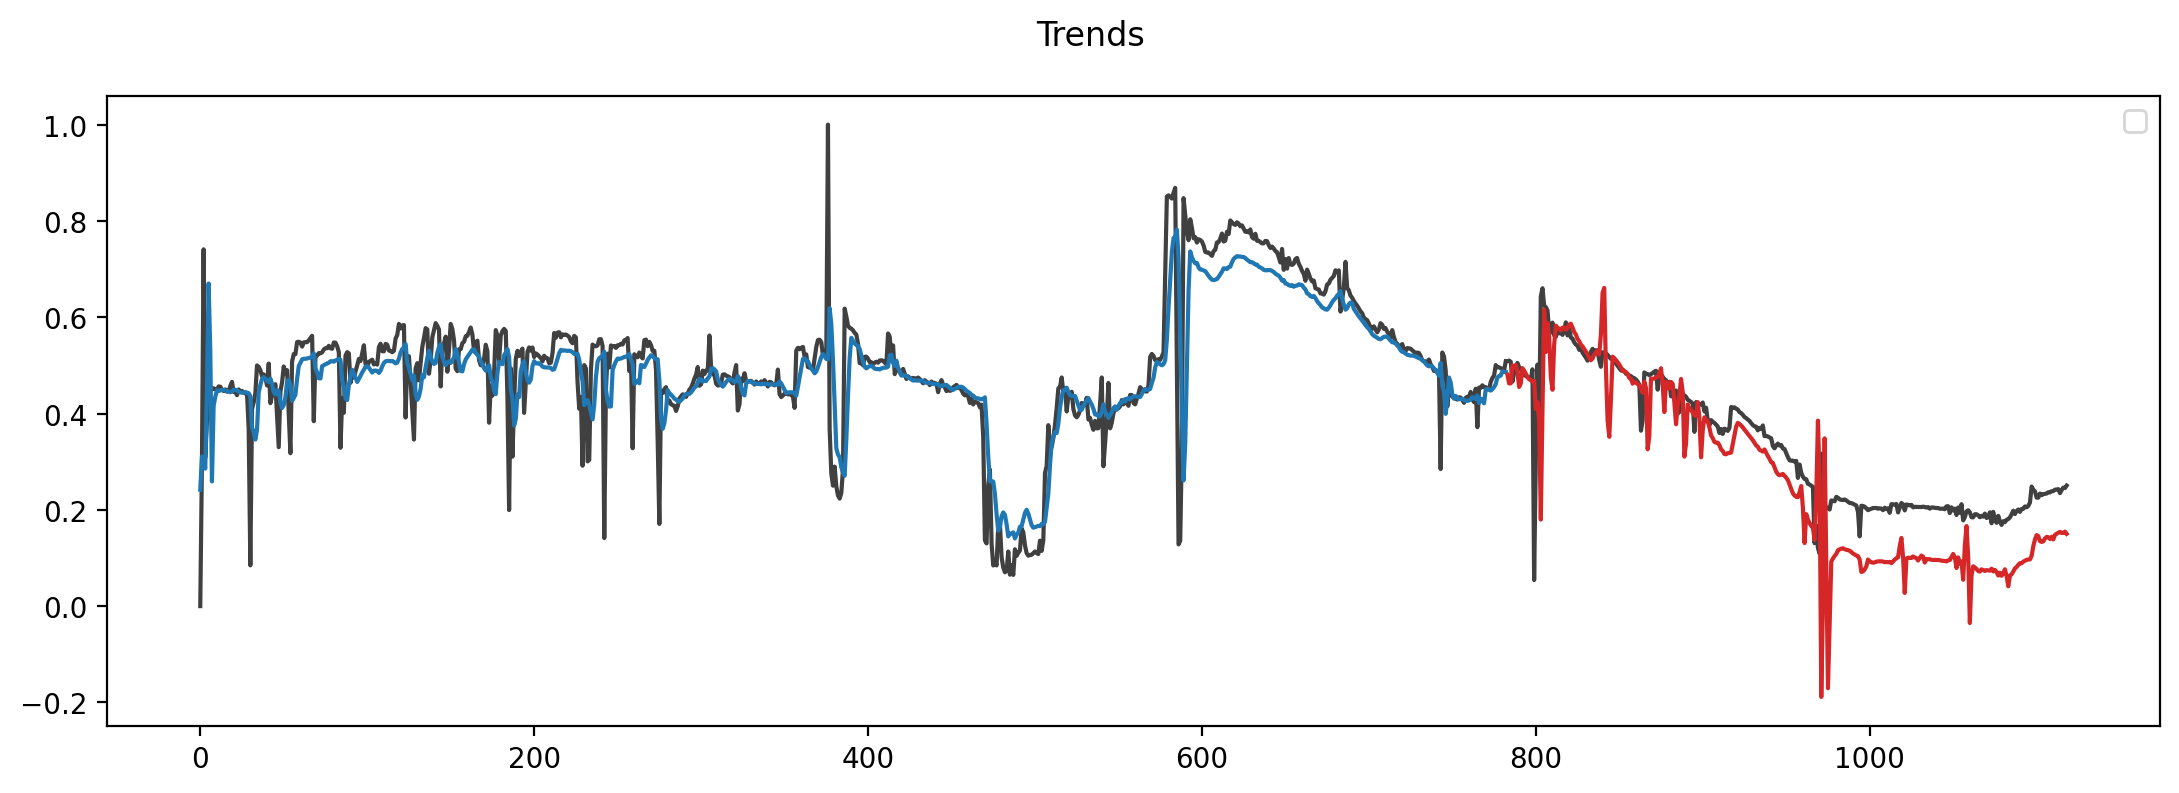

In [159]:
# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=["QG"],
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=["QG"],
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [163]:
# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

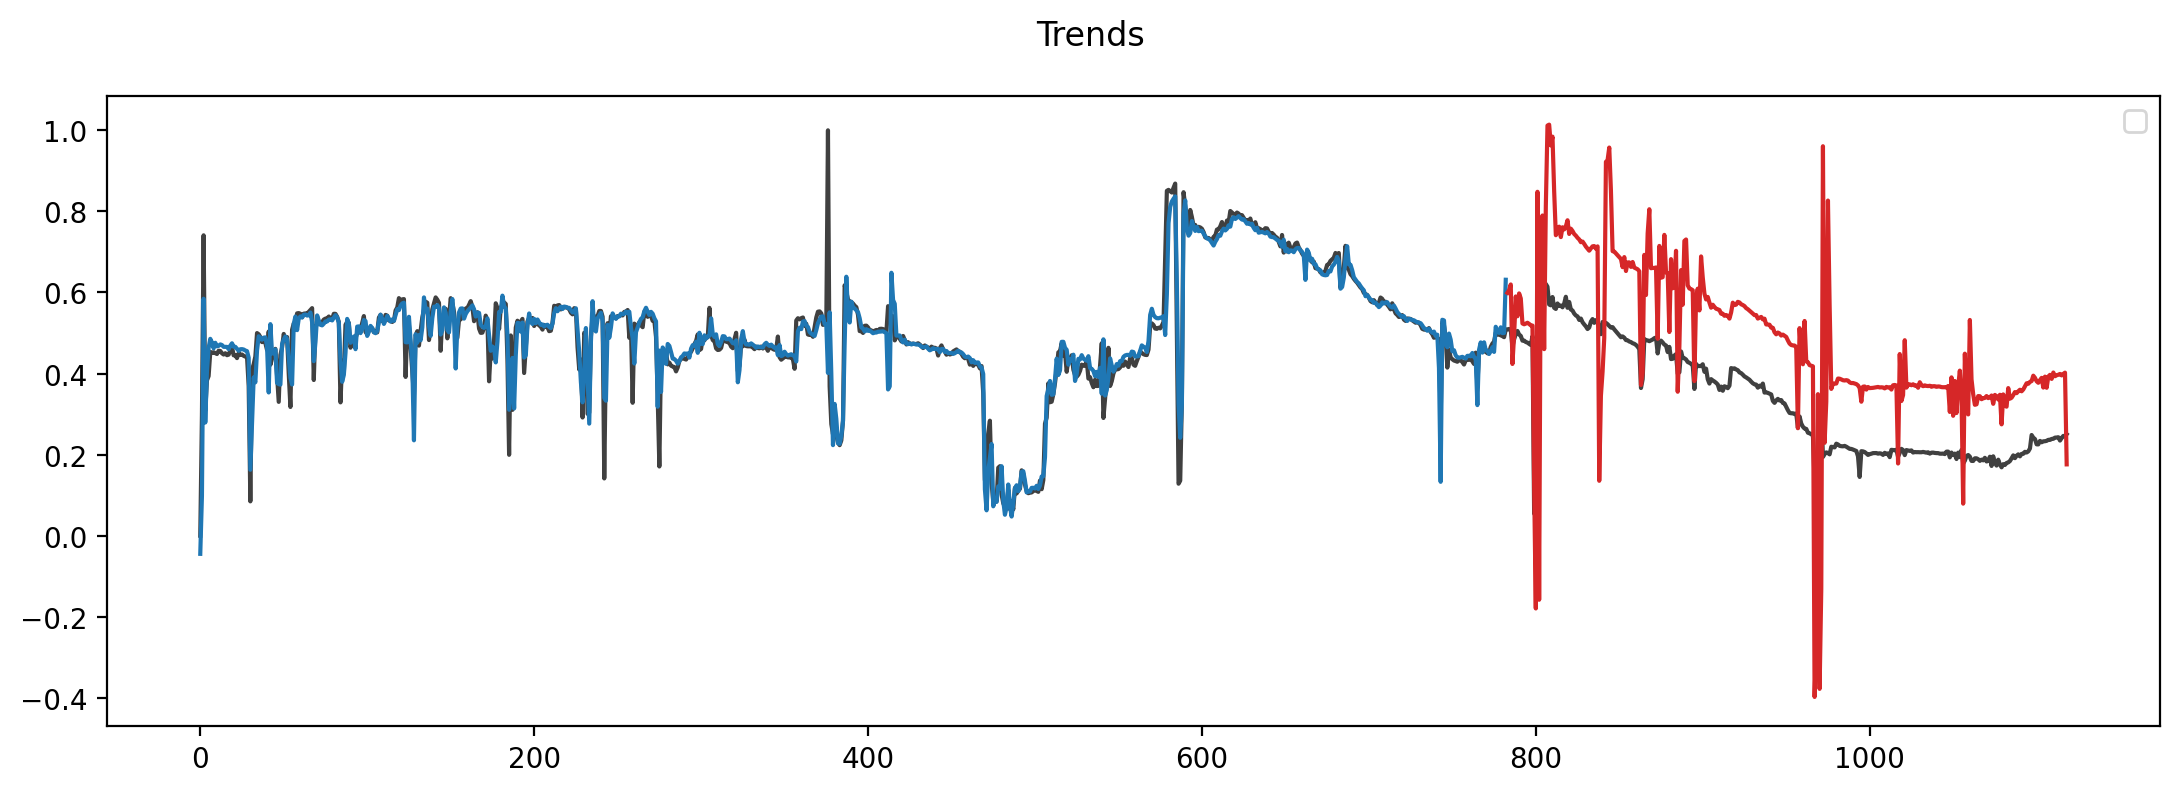

In [165]:
X_train = X.iloc[:nrow, :]
y_train = y[:nrow]
X_test = X.iloc[nrow:,:]
y_test = y[nrow:]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=["QG"],
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=["QG"],
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [168]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
# y_fit = y_fit.stack().squeeze()    # trend from training set
# y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit["QG"]

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit["QG"]
y_pred_boosted = xgb.predict(X_test) + y_pred["QG"]

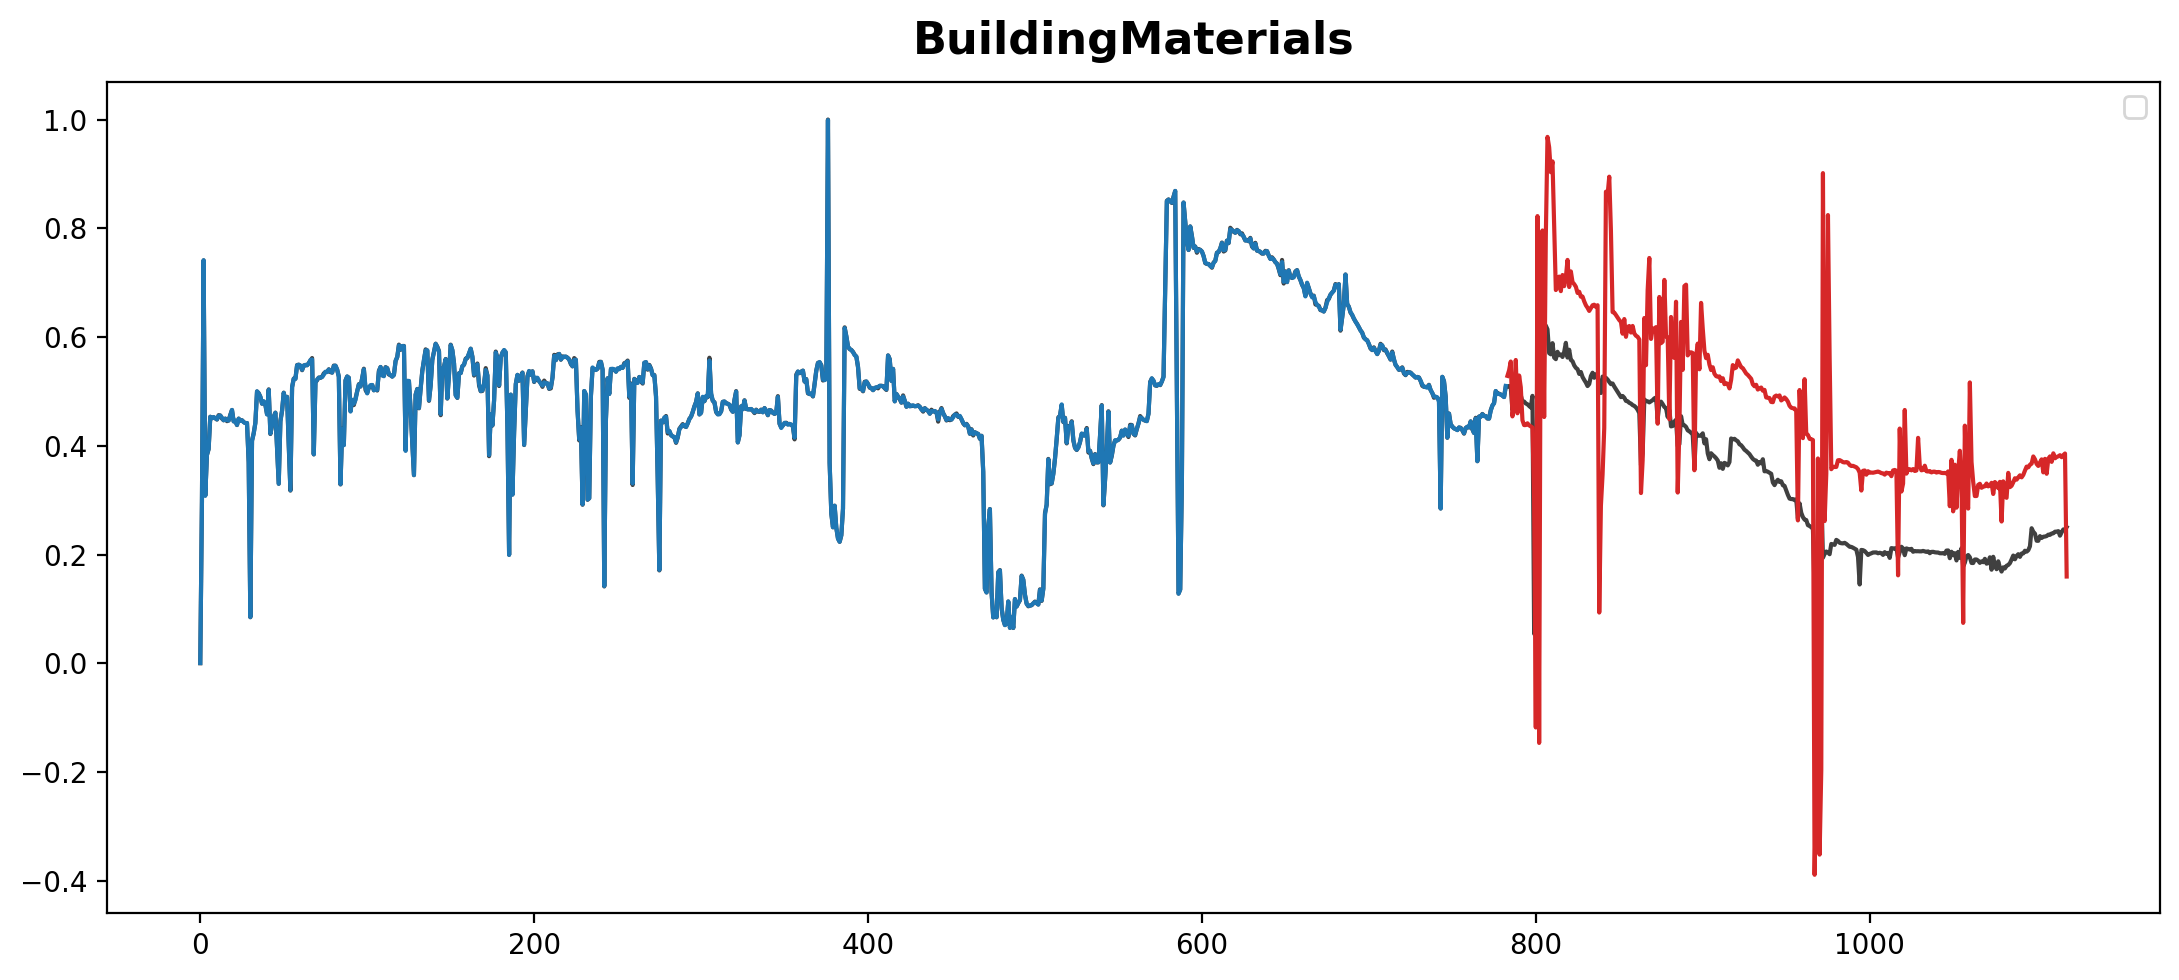

In [169]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials'],
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])